In [7]:
# اگر بسته‌ها را نصب نکرده‌اید، این سلول را اجرا کنید (یک‌بار کافی است)
# !pip install numpy pandas scipy scikit-learn matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split

# تنظیمات نمایشی
%matplotlib inline



In [8]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

print("movies:", movies.shape)
print(movies.head())
print("\nratings:", ratings.shape)
print(ratings.head())


movies: (9742, 3)
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

ratings: (100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


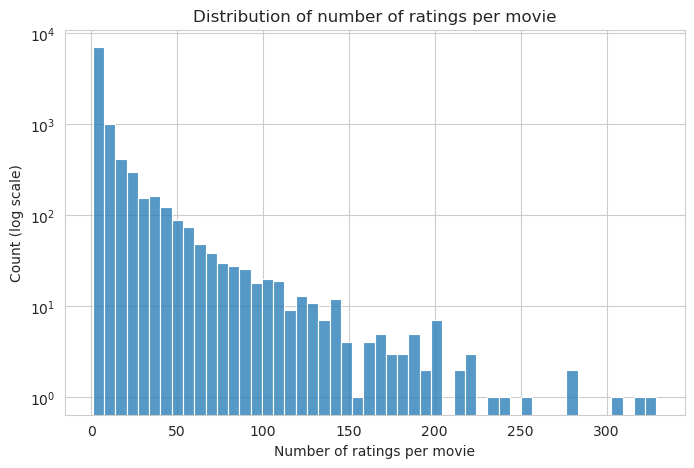

,movieId,count,mean_rating,title_clean
314,356,329,4.164134,Forrest Gump
277,318,317,4.429022,"Shawshank Redemption, The"
257,296,307,4.197068,Pulp Fiction
510,593,279,4.161290,"Silence of the Lambs, The"
1938,2571,278,4.192446,"Matrix, The"
224,260,251,4.231076,Star Wars: Episode IV - A New Hope
418,480,238,3.750000,Jurassic Park
97,110,237,4.031646,Braveheart
507,589,224,3.970982,Terminator 2: Judgment Day
461,527,220,4.225000,Schindler's List


In [16]:
# استخراج سال از title (اگر فرمت (YYYY) دارد)
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)', expand=False)
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')

# حذف سال از title برای تمیزی
movies['title_clean'] = movies['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()

# نمایش نمونه‌ای
movies[['movieId', 'title', 'title_clean', 'year', 'genres']].head()
# تعداد رأی‌ها به ازای هر فیلم
movie_counts = ratings.groupby('movieId').size().rename('count').reset_index()
movie_mean = ratings.groupby('movieId')['rating'].mean().rename('mean_rating').reset_index()
movie_stats = movie_counts.merge(movie_mean, on='movieId').merge(movies[['movieId','title_clean']], on='movieId')

plt.figure(figsize=(8,5))
sns.histplot(movie_stats['count'], bins=50)
plt.yscale('log')  # لاگ محور y به‌صورت جداگانه
plt.xlabel('Number of ratings per movie')
plt.ylabel('Count (log scale)')
plt.title('Distribution of number of ratings per movie')
plt.show()


# نمایش چند فیلم پرتعداد
movie_stats.sort_values('count', ascending=False).head(10)


In [11]:
# انتخاب ستون‌های مورد نیاز
print("Unique users:", ratings['userId'].nunique(), "Unique movies:", ratings['movieId'].nunique())

# Pivot برای ماتریس (NaN یعنی کاربر فیلم را ندیده/امتیازی نداده)
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
user_item_matrix.shape


Unique users: 610 Unique movies: 9724


(610, 9724)

In [12]:
# محاسبه آمار فیلم‌ها
movie_stats = ratings.groupby('movieId').agg({'rating': ['mean','count']})
movie_stats.columns = ['mean_rating','rating_count']
movie_stats = movie_stats.reset_index().merge(movies[['movieId','title_clean']], on='movieId')

# فقط فیلم‌هایی که حداقل N رأی دارند را نگه دار (مثلاً 50)
popular = movie_stats[movie_stats['rating_count'] >= 50].sort_values(['mean_rating','rating_count'], ascending=False)

def recommend_popular(user_id, k=10):
    seen = set(ratings[ratings['userId']==user_id]['movieId'].unique())
    candidates = popular[~popular['movieId'].isin(seen)]
    return candidates[['movieId','title_clean','mean_rating','rating_count']].head(k)

# مثال
recommend_popular(user_id=1, k=10)


,movieId,title_clean,mean_rating,rating_count
277,318,"Shawshank Redemption, The",4.429022,317
659,858,"Godfather, The",4.289062,192
974,1276,Cool Hand Luke,4.271930,57
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,4.268041,97
686,904,Rear Window,4.261905,84
921,1221,"Godfather: Part II, The",4.259690,129
6298,48516,"Departed, The",4.252336,107
694,912,Casablanca,4.240000,100
6693,58559,"Dark Knight, The",4.238255,149
950,1252,Chinatown,4.211864,59


In [ ]:
#روش دوم

In [13]:
# ساخت ماتریس item x user (fill 0 for missing)
item_user_matrix = ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)

# محاسبه شباهت آیتم‌ها (cosine)
item_sim = cosine_similarity(item_user_matrix)
item_sim_df = pd.DataFrame(item_sim, index=item_user_matrix.index, columns=item_user_matrix.index)

# تابع پیش‌بینی برای یک کاربر و فیلم با weighted sum
def predict_item_based(user_id, movie_id, item_sim_df, ratings_df):
    # فیلم‌هایی که کاربر امتیاز داده
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    if user_ratings.empty:
        return np.nan
    # شباهت فیلم موردنظر با همهٔ فیلم‌ها
    sims = item_sim_df.loc[movie_id, user_ratings['movieId']].values
    # امتیازات کاربر به آن فیلم‌ها
    r = user_ratings['rating'].values
    # وزن‌دهی و جمع
    if sims.sum() == 0:
        return np.nan
    return np.dot(sims, r) / np.sum(np.abs(sims))

# نمونه فرضی: پیش‌بینی امتیاز user 1 برای movie 1
example_pred = predict_item_based(user_id=1, movie_id=1, item_sim_df=item_sim_df, ratings_df=ratings)
example_pred


np.float64(4.37771715279353)

In [14]:
def recommend_item_based(user_id, k=10):
    seen = set(ratings[ratings['userId']==user_id]['movieId'].unique())
    candidates = [m for m in item_sim_df.index if m not in seen]
    preds = []
    for m in candidates:
        p = predict_item_based(user_id, m, item_sim_df, ratings)
        if not np.isnan(p):
            preds.append((m,p))
    preds = sorted(preds, key=lambda x: x[1], reverse=True)[:k]
    dfp = pd.DataFrame(preds, columns=['movieId','pred_rating']).merge(movies[['movieId','title_clean']], on='movieId')
    return dfp

# مثال
recommend_item_based(user_id=1, k=10)


,movieId,pred_rating,title_clean
0,1140,5.0,Entertaining Angels: The Dorothy Day Story
1,1519,5.0,Broken English
2,2896,5.0,Alvarez Kelly
3,3106,5.0,Come See the Paradise
4,3899,5.0,Circus
5,6158,5.0,"Jungle Book 2, The"
6,26366,5.0,Harlan County U.S.A.
7,44633,5.0,"Devil and Daniel Johnston, The"
8,58309,5.0,War Dance
9,63239,5.0,Cinderella


In [ ]:
#روش سوم

In [15]:
# ساخت dense matrix با NaN برای محاسبه میانگین کاربر
R = ratings.pivot(index='userId', columns='movieId', values='rating')
R_matrix = R.fillna(0).values

# محاسبه میانگین هر کاربر (برای centering)
user_ratings_mean = np.where(R.values != 0, R.values, np.nan).mean(axis=1)
# اگر NaN وجود داشته باشه (کاربر هیچ فیلمی نمره نداده) مقدار 0 قرار می‌دهیم:
user_ratings_mean = np.nan_to_num(user_ratings_mean)

R_demeaned = R_matrix - user_ratings_mean.reshape(-1,1)

# SVD
k = 50   # تعداد فاکتورهای پنهان، بسته به داده قابل تغییر است
U, sigma, Vt = svds(R_demeaned, k = k)
sigma = np.diag(sigma)

# بازسازی تخمین‌ها
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1,1)
preds_df = pd.DataFrame(all_user_predicted_ratings, index=R.index, columns=R.columns)

def recommend_svd(user_id, k=10):
    if user_id not in preds_df.index:
        return pd.DataFrame()
    user_pred = preds_df.loc[user_id].sort_values(ascending=False)
    seen = set(ratings[ratings['userId']==user_id]['movieId'].unique())
    recommended = user_pred[~user_pred.index.isin(seen)].head(k).reset_index()
    recommended.columns = ['movieId','pred_rating']
    recommended = recommended.merge(movies[['movieId','title_clean']], on='movieId')
    return recommended

# مثال
recommend_svd(user_id=1, k=10)


,movieId,pred_rating,title_clean
0,1036,4.009045,Die Hard
1,1221,3.303897,"Godfather: Part II, The"
2,1387,3.303409,Jaws
3,1968,2.869847,"Breakfast Club, The"
4,858,2.859630,"Godfather, The"
5,1259,2.785549,Stand by Me
6,2804,2.603560,"Christmas Story, A"
7,2080,2.455787,Lady and the Tramp
8,4011,2.403890,Snatch
9,2081,2.372148,"Little Mermaid, The"
